In [1]:
#pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [2]:
import re
import string
from time import time 

import torch
import torch.nn as nn
from tqdm import tqdm
from torchsummary import summary

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

### IMPORTING THE DATASET, TEXT PREPOCESSSING AND VOCAB BUILDING
(I am ignoring for the specific requirements of preprocessing for this task)

In [3]:
nltk.download('stopwords')
punct = string.punctuation
stopwords_english = stopwords.words('english')
stemmer = PorterStemmer()
path = '/kaggle/input/nlp-coursera-deep-learningai/Natural-Language-Processing-Specialization-master/Natural Language Processing with Probabilistic Models/Week 4/shakespeare.txt'

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def preprocessing(string, stopwords, stemmer):
    '''We can do all the preprocessing in just one step by creating a pipeline
    First, we have to make all the words in lowercase,
    then we have to tokenize the string,
    then we have to remove stopwords and 
    finally we have to stem all the words.
    This is how it will be ready to be analyzed further'''
    string = re.sub(r'\n', ' ', string)
    string  = string.lower()
    tokens = re.split('\s|(?<!\d)[,.](?!\d)', string)
    '''
    clean_tokens = []
    for word in tokens:
        if word not in stopwords:
            clean_tokens.append(word)
    '''
    stemmed_words = []
    for word in tokens:
        stemmed_words.append(stemmer.stem(word))
    
    preprocessed_array = []
    for word in stemmed_words:
        if word!='':
            preprocessed_array.append(word)
            
    return preprocessed_array
#########################################
#dataset['preprocessed'] = dataset['text'].apply(lambda x:preprocessing(x, stopwords_english, stemmer))    
#dataset.head(10)
with open(path) as f:
    data = f.read()
data = preprocessing(data, stopwords_english, stemmer)
print(len(data))

52202


In [5]:
def build_frequency(data):
    vocab = {}
    for word in data:
        if word in vocab.keys():
            vocab[word]+=1
        else:
            vocab[word] = 1
    return vocab
#####################################
vocab = build_frequency(data)
print(len(vocab))

6332


**First we have to figure out word2indices and indices2word dictionary for one hot encodings and form the final data**

In [6]:
unique_words = vocab.keys()
###################################
def word2ind_ind2word(unique_words):
    # 
    word2ind = {}
    ind2word  ={}
    for index, word in enumerate(unique_words):
        word2ind[word] = index
        ind2word[index] = word
    return word2ind, ind2word

word2ind, ind2word = word2ind_ind2word(unique_words)
########################################    

In [7]:
len(unique_words), len(word2ind), len(ind2word)

(6332, 6332, 6332)

**Now we have to form the data, first we have to form the data for a single string with the help of sliding windows and word2index dictionary**

In [8]:
# hyperparameters
C=2
intermediate_length = 300
one_hot_length = len(unique_words)

def build_data(processed_tweet, word2ind=word2ind, in2word=ind2word, C=2, one_hot_length=one_hot_length):    
    # string will be a one token list
    data = []
    for i in range(C, len(processed_tweet)-C):
        x = np.zeros(one_hot_length+1, dtype=np.float32)
        temp_list = processed_tweet[i-C:i] + processed_tweet[i+1:i+C+1]
        for word in temp_list:
           x[word2ind[word]]+= 1
        x/=(2*C)
        x[one_hot_length] = word2ind[processed_tweet[i]]
        data.append(x)
    return data


### **Model for CBOW**
* Now for capturing the context of the words we will apply the cbow model where c=2 and take the intermediate length of the vectors to be 300

In [9]:
class CBOW(nn.Module):
    def __init__(self, length, intermediate_len):
        super(CBOW, self).__init__()
        layers = []
        layers.append(nn.Linear(in_features=length, out_features=intermediate_len))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(in_features=intermediate_len, out_features=length))
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cbow = CBOW(length=len(unique_words), intermediate_len=300).to(device)
summary(cbow, (len(unique_words), ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 300]       1,899,900
              ReLU-2                  [-1, 300]               0
            Linear-3                 [-1, 6332]       1,905,932
Total params: 3,805,832
Trainable params: 3,805,832
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.05
Params size (MB): 14.52
Estimated Total Size (MB): 14.60
----------------------------------------------------------------


### **UTILS**

In [11]:
def compute_pca(data, n_components=2):
    """
    Input: 
        data: of dimension (m,n) where each row corresponds to a word vector
        n_components: Number of components you want to keep.
    Output: 
        X_reduced: data transformed in 2 dims/columns + regenerated original data
    pass in: data as 2D NumPy array
    """

    m, n = data.shape

    ### START CODE HERE ###
    # mean center the data
    data -= data.mean(axis=0)
    # calculate the covariance matrix
    R = np.cov(data, rowvar=False)
    # calculate eigenvectors & eigenvalues of the covariance matrix
    # use 'eigh' rather than 'eig' since R is symmetric,
    # the performance gain is substantial
    evals, evecs = np.linalg.eigh(R)
    # sort eigenvalue in decreasing order
    # this returns the corresponding indices of evals and evecs
    idx = np.argsort(evals)[::-1]

    evecs = evecs[:, idx]
    # sort eigenvectors according to same index
    evals = evals[idx]
    # select the first n eigenvectors (n is desired dimension
    # of rescaled data array, or dims_rescaled_data)
    evecs = evecs[:, :n_components]
    ### END CODE HERE ###
    return np.dot(evecs.T, data.T).T

In [12]:
def save_checkpoint(state, filename='my_checkpoint.pth.tar'):
    # will save model and optimizer params at every epoch
    print("-> Saving CheckPoint")
    torch.save(state, filename)

In [13]:
def load_checkpoint(checkpoint, model):
    # it will just load, we can train it further, make changes to the architecture
    # and simply use it to predict
    print("-> Loading CheckPoint")
    model.load_state_dict(checkpoint["state_dict"])

In [14]:
def train(loader, model, optimizer, loss_fn, scaler, device=device):
    '''
    it is the training procedure for one epoch of the network
    '''
    num_batches = len(loader)
    batches = tqdm(loader) # tqdm will be used to generate progress bars
    acc = 0
    for idx, batch in enumerate(batches, 0):
        inp = batch[:, :-1].type(torch.float32).to(device)  # shape is (32, len(unique_words))
        target = batch[:, -1].type(torch.LongTensor).to(device) # shape is (32,)
        
        # forward
        #with torch.cuda.amp.autocast(): # for gradient underflowing and overflowing and it makes training faster by converting all floats to float16
        pred = model(inp)
        loss = loss_fn(pred, target) 
            
        optimizer.zero_grad()  # making all the previous gradients zero 
        #scaler.scale(loss).backward()
        loss.backward()
        #scaler.step(optimizer)
        #scaler.update()
        optimizer.step()
        
        
        model.eval()
        with torch.no_grad():
            acc += (torch.argmax(pred, dim=1)==target).sum().item()/batch_size
        batches.set_postfix(loss = loss.item()) # loss of this current batch on current iteration 
        model.train()

    acc/=num_batches
    print(f"Validation accuracy is {acc*100}")

### **DRIVER CODE**

In [15]:
# hyperparameters
lr = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32
num_workers = 2
num_epochs = 50 # just for testing if loop works fine else i am gonna set it to 100

# set up the input data
with open(path) as f:
    data = f.read()
data = preprocessing(data, stopwords_english, stemmer)
train_data = build_data(data) 
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True,
                                           num_workers=num_workers)


#setting up the model, scaler, optimizer, loss_fn
model = CBOW(length=len(unique_words), intermediate_len=300).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scaler = None
if torch.cuda.is_available():
    scaler = torch.cuda.amp.GradScaler()

In [ ]:
# now training 
for epoch in range(num_epochs):
    train(train_loader, model, optimizer, loss_fn, scaler)
    
    # save checkpoints 
    checkpoint = {
        'state_dict': model.state_dict(),
        'optimizer':optimizer.state_dict()
    }
    save_checkpoint(checkpoint)
    

100%|██████████| 1632/1632 [00:12<00:00, 135.15it/s, loss=7.97]


Validation accuracy is 3.4964767156862746
-> Saving CheckPoint


100%|██████████| 1632/1632 [00:11<00:00, 141.25it/s, loss=5.89]


Validation accuracy is 6.0431985294117645
-> Saving CheckPoint


100%|██████████| 1632/1632 [00:11<00:00, 141.22it/s, loss=5.97]


Validation accuracy is 8.071001838235293
-> Saving CheckPoint


100%|██████████| 1632/1632 [00:12<00:00, 134.81it/s, loss=6.59]


Validation accuracy is 11.142386642156863
-> Saving CheckPoint


100%|██████████| 1632/1632 [00:11<00:00, 139.23it/s, loss=5.24]


Validation accuracy is 14.732689950980394
-> Saving CheckPoint


100%|██████████| 1632/1632 [00:11<00:00, 140.65it/s, loss=3.9] 


Validation accuracy is 18.384267769607842
-> Saving CheckPoint


100%|██████████| 1632/1632 [00:11<00:00, 137.21it/s, loss=4.16]


Validation accuracy is 22.033930759803923
-> Saving CheckPoint


100%|██████████| 1632/1632 [00:11<00:00, 143.27it/s, loss=3.05]


Validation accuracy is 25.792738970588236
-> Saving CheckPoint


100%|██████████| 1632/1632 [00:12<00:00, 135.91it/s, loss=4.67]


Validation accuracy is 29.61282169117647
-> Saving CheckPoint


100%|██████████| 1632/1632 [00:11<00:00, 140.24it/s, loss=3.92]


Validation accuracy is 34.091605392156865
-> Saving CheckPoint


100%|██████████| 1632/1632 [00:11<00:00, 140.72it/s, loss=2.31]


Validation accuracy is 42.28132659313725
-> Saving CheckPoint


100%|██████████| 1632/1632 [00:11<00:00, 136.11it/s, loss=2.18]


Validation accuracy is 52.232689950980394
-> Saving CheckPoint


100%|██████████| 1632/1632 [00:11<00:00, 142.57it/s, loss=2.08]


Validation accuracy is 59.34627757352941
-> Saving CheckPoint


100%|██████████| 1632/1632 [00:11<00:00, 141.80it/s, loss=1.34]


Validation accuracy is 64.41674325980392
-> Saving CheckPoint


100%|██████████| 1632/1632 [00:12<00:00, 134.73it/s, loss=2.49] 


Validation accuracy is 68.56617647058823
-> Saving CheckPoint


100%|██████████| 1632/1632 [00:11<00:00, 141.77it/s, loss=1.89] 


Validation accuracy is 72.11052389705883
-> Saving CheckPoint


 30%|███       | 492/1632 [00:03<00:07, 143.36it/s, loss=1.1]  

### **THESE WORD VECTORS ARE TRAINED SO THAT THEY CAN LEARN THE CONTEXT**

In [22]:
w1 = model.state_dict()['model.0.weight']
w2 = model.state_dict()['model.2.weight']
print(w1.shape, w2.shape)
weights = w1 + w2.T
print(weights.shape)

torch.Size([300, 6332]) torch.Size([6332, 300])
torch.Size([300, 6332])


### **Now we have to simply assign the embeddings to their words**

In [23]:
def embeddings(weights, ind2word = ind2word):
    weights = weights.detach().cpu().numpy()
    embed = {}
    for key in ind2word.keys():
        embed[ind2word[key]] = weights[:, key]
    return embed

######################
word_embeddings = embeddings(weights)

### **TESTING THE QUALITY OF WORD EMBEDDINGS THROUGH VISUALIZATION AND ANALOGIES**
- We can apply many things here, first of all we can simply check if the classes are predicted correct or not on a given example.
- Then we can apply PCA to the embddings and plot them to visulaize correlations between the words and get a understanding of how correct the embddings are.
- As embeddings are built for use for some task, the ultimate check of them is to apply to that particular task and then get feedback from there, like if i wished to design embeddings for question-answering then i will train model and then how good the model is doing in question-answering, this will ultimately tell us the quality of our embedding

### **First test**

In [24]:
# now let us try to predict middle word, giving context to the right and left of it
with open(path) as f:
    test_data = f.read() # although training and testing data are same
test_data = preprocessing(test_data, stopwords_english, stemmer)


##########################
indices = range(4000, 5000, 50)
for i, index in enumerate(indices, 1):
    context_words = test_data[index-C:index] + test_data[index+1:index+C+1] 
    print(f"Example {i} - ")
    test_x_array = np.array(build_data(test_data[index-C:index+C+1]))
    test_x_tensor = torch.tensor(test_x_array[:, :-1], dtype=torch.float32).to(device)
    test_op = model(test_x_tensor)
    test_op = ind2word[test_op.argmax(dim=1).item()]
    print(f"Context words : {context_words}\nActual middle word : '{test_data[index]}'\nPredicted context word :'{test_op}'\n\n\n")


Example 1 - 
Context words : ['here', 'live', 'thi', 'come']
Actual middle word : 'against'
Predicted context word :'against'



Example 2 - 
Context words : ['so', 'fair', 'hous', 'fall']
Actual middle word : 'a'
Predicted context word :'a'



Example 3 - 
Context words : ['do', 'i', 'judgement', 'pluck']
Actual middle word : 'my'
Predicted context word :'my'



Example 4 - 
Context words : ['go', 'well', 'oft', 'predict']
Actual middle word : 'by'
Predicted context word :'by'



Example 5 - 
Context words : ['thi', 'end', "truth'", 'and']
Actual middle word : 'is'
Predicted context word :'is'



Example 6 - 
Context words : ['even', 'by', 'self-sam', 'sky:']
Actual middle word : 'the'
Predicted context word :'the'



Example 7 - 
Context words : ['sulli', 'night', 'all', 'in']
Actual middle word : 'and'
Predicted context word :'and'



Example 8 - 
Context words : ['barren', 'rhyme?', 'stand', 'you']
Actual middle word : 'now'
Predicted context word :'now'



Example 9 - 
Context wor

### **So it learnt the context pretty well (actually overfitted 😢🙂)**

### **Second test**

(10, 300)


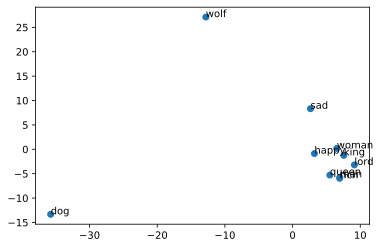

In [25]:
# visualizing the word vectors here
from matplotlib import pyplot
#%config InlineBackend.figure_format = 'svg'
words = ['king', 'queen','lord','man', 'woman','dog','wolf',
         'rich','happy','sad']
 
# given a list of words and the embeddings, it returns a matrix with all the embeddings
X = np.array([word_embeddings[stemmer.stem(word)] for word in words])
print(X.shape)  # X.shape:  Number of words of dimension N each 


#################### plotting part
result= compute_pca(X, 2)
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [26]:
'''
cosine_similarity = lambda vec1, vec2:np.dot(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))

happy = word_embeddings[stemmer.stem('happy')]
sad = word_embeddings[stemmer.stem('sad')]
king = word_embeddings[stemmer.stem('king')]

# let us try to find out the analogies
similarities = []
for word in words:
    if word!='king':
        similarities.append(cosine_similarity(happy-sad, king-word_embeddings[stemmer.stem(word)]))
    else:
        similarities.append(0.0)
        
print(similarities)
temp = np.argsort(similarities)
temp = temp[::-1]
print(f"Top 5 similar words to king are - ")
for i in range(5):
    print(f"{words[temp[i]]}, ")

print(" ")
'''

[0.0, 0.013433049, 0.04355016, -0.083640724, 0.05904426, 0.016517315, 0.10437238, 0.06497485, -0.3679134, 0.6371533]
Top 5 similar words to king are - 
sad, 
wolf, 
rich, 
woman, 
lord, 
 
